<a href="https://colab.research.google.com/github/yarayear2056-cmd/Week4_pro/blob/main/chest_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/chest_xray


/content/drive/MyDrive/chest_xray


In [ ]:
base_path = '/content/drive/MyDrive/chest_xray'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_set_full = datasets.ImageFolder(os.path.join(base_path, 'train'), transform=transform)
val_set = datasets.ImageFolder(os.path.join(base_path, 'val'), transform=transform)
test_set = datasets.ImageFolder(os.path.join(base_path, 'test'), transform=transform)

In [ ]:
small_size = int(0.1 * len(train_set_full))
indices = torch.randperm(len(train_set_full))[:small_size]
train_set_small = Subset(train_set_full, indices)

In [ ]:
train_loader_large = DataLoader(train_set_full, batch_size=32, shuffle=True)
train_loader_small = DataLoader(train_set_small, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)

In [ ]:
num_classes = len(train_set_full.classes)

In [ ]:
def get_model(freeze_backbone=True):
    model = models.resnet18(weights='IMAGENET1K_V1')

    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

In [ ]:
def run_research_experiment(name, model, loader):
    print(f"\n--- Running Experiment: {name} ---")
    criterion = nn.CrossEntropyLoss()
    # تحسين فقط المعاملات التي تتطلب تحديث (حسب حالة الـ Freeze)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    for epoch in range(3):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            # عملية التدريب القياسية حسب توثيق PyTorch
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # حساب الإحصائيات (Loss & Accuracy)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1) # اختيار الفئة ذات الاحتمالية الأعلى
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(loader.dataset)
        epoch_acc = 100 * correct / total

        print(f"Epoch [{epoch+1}/3] | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

In [ ]:
model_frozen_small = get_model(freeze_backbone=True)
run_research_experiment("freeze + small data", model_frozen_small, train_loader_small)


--- Running Experiment: freeze + small data ---
Epoch [1/3] | Loss: 0.6270 | Accuracy: 70.06%
Epoch [2/3] | Loss: 0.4126 | Accuracy: 81.19%
Epoch [3/3] | Loss: 0.3207 | Accuracy: 83.69%


In [ ]:
model_frozen_large = get_model(freeze_backbone=True)
run_research_experiment("freeze + large data", model_frozen_large, train_loader_large)


--- Running Experiment: freeze + large data ---
Epoch [1/3] | Loss: 0.2741 | Accuracy: 88.67%
Epoch [2/3] | Loss: 0.1652 | Accuracy: 93.44%
Epoch [3/3] | Loss: 0.1396 | Accuracy: 94.67%


In [ ]:
model_unfreeze_small = get_model(freeze_backbone=False)
run_research_experiment("unfreeze + small data", model_unfreeze_small, train_loader_small)


--- Running Experiment: unfreeze + small data ---
Epoch [1/3] | Loss: 0.2306 | Accuracy: 90.60%
Epoch [2/3] | Loss: 0.1701 | Accuracy: 94.24%
Epoch [3/3] | Loss: 0.0457 | Accuracy: 98.08%


In [ ]:
model_unfreeze_large = get_model(freeze_backbone=False)
run_research_experiment("unfreeze + large data", model_unfreeze_large, train_loader_large)


--- Running Experiment: unfreeze + large data ---
Epoch [1/3] | Loss: 0.1163 | Accuracy: 95.61%
Epoch [2/3] | Loss: 0.0832 | Accuracy: 97.07%
Epoch [3/3] | Loss: 0.0381 | Accuracy: 98.56%



--- Final Classification Report ---
              precision    recall  f1-score   support

      NORMAL       0.99      0.45      0.62       234
   PNEUMONIA       0.75      1.00      0.86       390

    accuracy                           0.79       624
   macro avg       0.87      0.73      0.74       624
weighted avg       0.84      0.79      0.77       624



<Figure size 800x600 with 0 Axes>

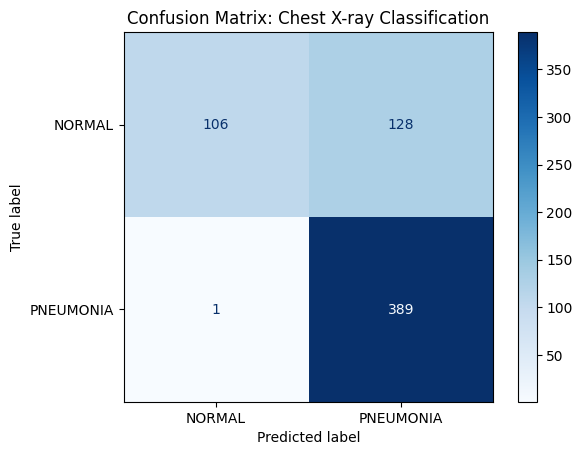

In [ ]:
def evaluate_final_model(model, loader, device):

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    print("\n--- Final Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=loader.dataset.classes))

    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=loader.dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix: Chest X-ray Classification')
    plt.show()

evaluate_final_model(model_unfreeze_large, test_loader, device)